# Geospatial Data Analysis - Raster Data
Geospatial data such as satellite imagery or elevation model are represented as one or more matrices of values. For example an image is usually represented as three matrices (bands) of values in the Red, Blue or Green colors. Each pixel of the image is represented by three RGB values. Satellite imagery may have more than three bands depending on the type of sensor used in the acquisition. Digital elevetion models (DEMs) and land cover models are represented as single band raster data. In this section we'll see how raster data can be read, processed and written in a file.

The upper-left corner of an image represents the origin (0, 0). The x axis goes from the origin to the left while the y axis goes from the origin to the bottom of the image. We use GDAL to read and write GeoTIFF files that contain the raster data and metadata. We use the [PIL](https://pillow.readthedocs.io/en/stable/index.html) Python package to render the images and Matplotlib to visualize them in the notebook.

In [1]:
import os
from osgeo import gdal
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

We want to stack three raster images, acquired by a Landsat satellite, into a GeoTIFF file so that they can be used as RGB bands. Let's have a look at one of them

TIFF (8849, 8023) L


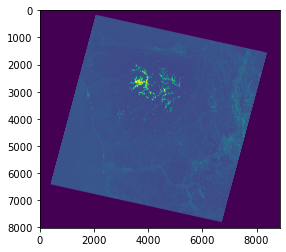

In [2]:
path = 'data/raster/Landsat/Washington/'
band1_fn = path + 'p047r027_7t20000730_z10_nn10.tif'
band2_fn = path + 'p047r027_7t20000730_z10_nn20.tif'
band3_fn = path + 'p047r027_7t20000730_z10_nn30.tif'
im_band1 = Image.open(band1_fn)
print(im_band1.format, im_band1.size, im_band1.mode)
plt.imshow(im_band1)

The image files are provided in GeoTIFF format with one single band so we extract information from their metadata such as the image size for each dimension, the spatial reference system and the coordinates of the origin.

In [3]:
in_ds = gdal.Open(band1_fn)
in_band = in_ds.GetRasterBand(1)
in_band.XSize, in_band.YSize, in_band.DataType, in_ds.GetProjection()

(8849,
 8023,
 1,
 'PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]')

In [4]:
x_origin, x_pixel_resolution, row_rotation, y_origin, column_rotation, y_pixel_resolution = in_ds.GetGeoTransform()
print('x_origin: {}, y_origin: {}'.format(x_origin, y_origin))

x_origin: 343724.25, y_origin: 5369585.25


We create a new GeoTIFF file with three bands of the same size and spatial reference system as the images

In [5]:
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create(path + 'nat_color.tif', in_band.XSize, in_band.YSize, 3, in_band.DataType)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())

0

We copy the raster data of the 1st image into the 3rd band of the created GeoTIFF file

In [6]:
in_data = in_band.ReadAsArray()
out_band = out_ds.GetRasterBand(3)
out_band.WriteArray(in_data)

0

We open the 2nd image and we put the raster data into the 2nd band

In [7]:
in_ds = gdal.Open(band2_fn)
out_band = out_ds.GetRasterBand(2)
out_band.WriteArray(in_ds.ReadAsArray())

0

Finally we put the 3rd image into the 1st band

In [8]:
in_ds = gdal.Open(band3_fn)
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(in_ds.ReadAsArray())

0

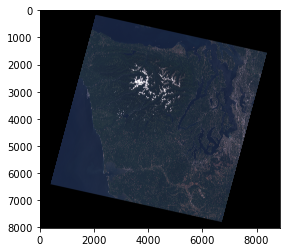

In [9]:
im_natcol = Image.open('nat_color.tif')
plt.imshow(im_natcol)

we write the data on disk

In [10]:
out_ds.FlushCache() 

we compute some statistical values for each band: mean, min, max and standard deviation. We create also some overview layers for each band to be visualized at different zoom levels.

In [11]:
for i in range(1, 4):
    out_ds.GetRasterBand(i).ComputeStatistics(False)
    out_ds.BuildOverviews('average', [2, 4, 8, 16, 32])
del out_ds

NameError: name 'out_ds' is not defined

### Raster data subsetting